In [1]:
import sys
sys.path.append("Methods/EWC/old")

In [2]:
from lib.abstract_torch import get_device, get_optimizer, get_loss
from lib.benchmark_generator import PermutedMNIST
from lib.models import ANN
from lib.train import train
from lib.test import test
from lib.visualize import vizualize_loss_hists, visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from avalanche.training.supervised import EWC
from avalanche.training.plugins import EWCPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [4]:
device = get_device(1)

## Set parameters

In [5]:
# Benchmark parameter
num_tasks = 3
train_percentage = 0.5

# EWC parameter
ewc_lambda = 400

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 1e-3

## Reproducibility

In [6]:
random_seed = 88

## Get p-MNIST benchmark

In [7]:
benchmark = PermutedMNIST(n_experiences=num_tasks, train_percentage=train_percentage, difficulty="hard", seed=random_seed)

In [8]:
import torch

In [9]:
test_loaders_list = []
for test_experience in benchmark.test_stream :
        test_dataset = test_experience.dataset
        test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        test_loaders_list.append(test_data_loader)

## Define model

In [10]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

## Train with EWC

In [11]:
optimizer = get_optimizer(optimizer_name, model)

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

print((ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data> 1e-6).sum())

In [13]:
experience = benchmark.train_stream[0]
ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data

tensor([[8.1090e-08, 1.4339e-07, 4.1090e-07,  ..., 8.0889e-08, 9.2642e-07,
         1.5635e-07],
        [1.0933e-07, 2.1939e-07, 4.8679e-07,  ..., 1.0902e-07, 9.6112e-07,
         3.3286e-07],
        [1.1039e-07, 5.7793e-07, 4.4966e-07,  ..., 1.0931e-07, 1.4394e-06,
         2.9165e-07],
        ...,
        [5.3784e-08, 2.4057e-07, 1.7794e-07,  ..., 5.3252e-08, 7.1293e-07,
         7.3055e-08],
        [4.6986e-08, 2.2820e-07, 3.2057e-07,  ..., 4.6848e-08, 4.3729e-07,
         9.3748e-08],
        [1.3741e-07, 4.2705e-07, 6.2264e-07,  ..., 1.3689e-07, 1.8694e-06,
         1.9580e-07]], device='cuda:1')

In [14]:
ewc.plugins[0].importances

defaultdict(dict, {})

In [15]:
test_accs_matrix = np.zeros((num_tasks, num_tasks))
for task_number, train_experience, test_experience in zip(list(range(num_tasks)), benchmark.train_stream, benchmark.test_stream) :
    ewc.train(train_experience)
    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)

-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 235/235 [00:03<00:00, 60.57it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8756
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 235/235 [00:03<00:00, 71.01it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9603
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 235/235 [00:05<00:00, 43.72it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9689
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 67.83it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8678
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 235/235 [00:04<00:00, 54.98it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9520
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 235/235 [00:05<00:00, 4

## Visualize results

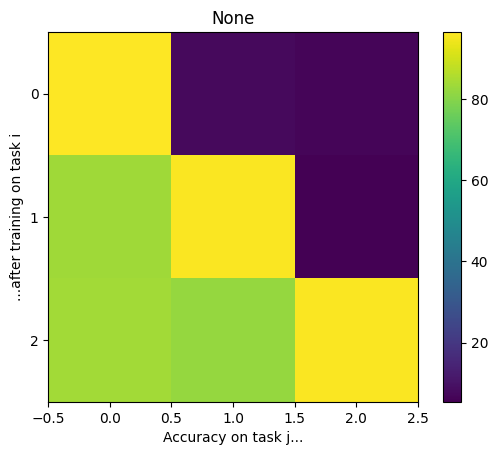

In [16]:
visualize_accs_matrix(test_accs_matrix)

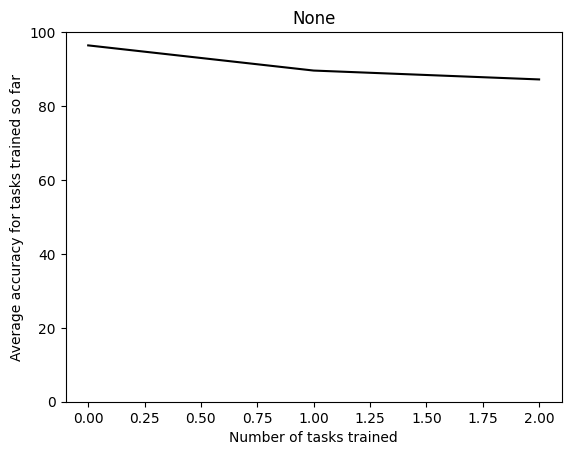

In [17]:
visualize_avg_acc_curve(test_accs_matrix)

In [18]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)
optimizer = get_optimizer(optimizer_name, model)

In [19]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

In [20]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [21]:
#ewc.plugins[0].importances[0] = sto[0]
#ewc.plugins[3].train_exp_counter = 1

In [22]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [23]:
ewc = EWC(
        model=model, 
        optimizer=get_optimizer(optimizer_name, model),
        criterion=get_loss(loss_name),
        ewc_lambda=0,
        train_mb_size=batch_size,
        train_epochs=0, 
        eval_every=-1,
        device=device
    )

In [24]:
id(ewc.model)

130955066063952

In [25]:
ewc.train_epochs

0

In [26]:
sto_ewc = None
test_accs_matrix = np.zeros((num_tasks, num_tasks))
for task_number, train_experience in zip(list(range(num_tasks)), benchmark.train_stream) :
    # Define the EWC Plugin
    if task_number != 0:
        ewc = sto_ewc
    else :
        ewc = EWC(
        model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
        train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
        device=device
        )
    
    if task_number == 2:
        ewc.plugins[0].ewc_lambda = 4000000

    ewc.train(train_experience)

    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)
    sto_ewc = ewc

-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 235/235 [00:03<00:00, 63.53it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8587
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9167
100%|██████████| 235/235 [00:03<00:00, 71.56it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9584
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 235/235 [00:05<00:00, 39.68it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9702
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 235/235 [00:04<00:00, 48.01it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8663
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8750
100%|██████████| 235/235 [00:03<00:00, 59.60it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9489
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9792
100%|██████████| 235/235 [00:03<00:00, 6

## Visualize results

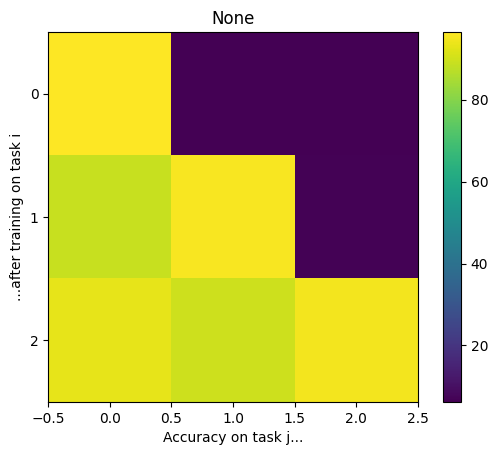

In [27]:
visualize_accs_matrix(test_accs_matrix)

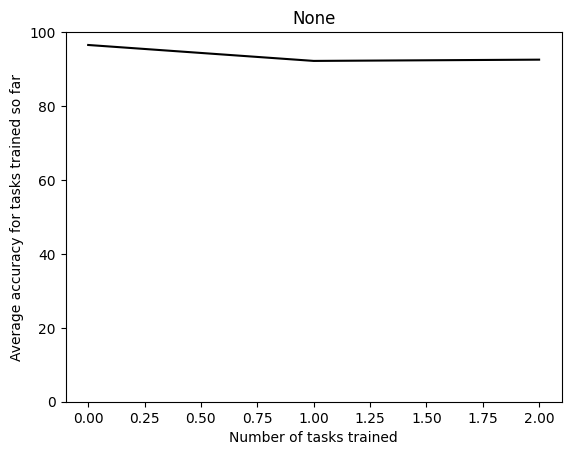

In [28]:
visualize_avg_acc_curve(test_accs_matrix)